In [1]:
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow-datasets
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

2025-01-15 20:26:22.749194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 20:26:22.924486: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 20:26:24.004376: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-15 20:26:24.004462

In [3]:
# Load original model
original_model_base = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model_base.trainable = False  # Freeze weights
original_model_strong = tf.keras.models.load_model('CNNModel/StrongCNN.keras')  # Replace with your model file
original_model_strong.trainable = False  # Freeze weights
original_model_simple = tf.keras.models.load_model('CNNModel/simpleCNN.keras')  # Replace with your model file


original_model_simple.trainabl=False

original_model = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model.trainable = False  # Freeze weights



2025-01-15 20:26:29.271990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16487 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-01-15 20:26:29.274661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20682 MB memory:  -> device: 1, name: NVIDIA A10, pci bus id: 0000:ca:00.0, compute capability: 8.6


In [4]:
# @ layers with 2 deconvolution layers
def build_atn(input_shape):
    model = tf.keras.Sequential([
        # First convolutional layers to capture features
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),  # Downsample (14, 14, 64)

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample (7, 7, 128)

        # Fully connected layer to integrate features
        layers.Flatten(),  # Flatten to shape (7 * 7 * 128 = 6272)
        layers.Dense(6272, activation='relu'),  # Match the reshape target

        # Deconvolution layers to reconstruct adversarial examples
        layers.Reshape((7, 7, 128)),  # Reshape for deconvolution
        layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),  # (14, 14, 128)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),  # (28, 28, 64)
        
        layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),  # Output layer (28, 28, 1)
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model

# Build the ATN
input_shape = (28, 28, 1)  # MNIST dataset shape
atn = build_atn(input_shape)


In [5]:
# Define ATN 2 Layers only convulution
###
'''
def build_atn(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]
        layers.Reshape(input_shape),
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model


input_shape = (28, 28, 1)  # Assuming MNIST dataset
atn = build_atn(input_shape)
'''

"\ndef build_atn(input_shape):\n    model = tf.keras.Sequential([\n        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(64, (3, 3), activation='relu'),\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]\n        layers.Reshape(input_shape),\n        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]\n    ])\n    return model\n\n\ninput_shape = (28, 28, 1)  # Assuming MNIST dataset\natn = build_atn(input_shape)\n"

In [6]:
# Define input loss and output loss function
def input_loss(x, x_prime):
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float32) - x_prime))  # Cast x to float32  # L2 loss

def output_loss(y_pred, y_target):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_target, y_pred)) # crossentropy



In [7]:
def get_second_highest_target(y_pred_original):
    # Sort predictions to find the highest and second-highest indices
    top_2_indices = tf.argsort(y_pred_original, direction='DESCENDING', axis=1)[:, :2]
    second_highest_indices = top_2_indices[:, 1]

    # Create one-hot encoding for the second-highest class
    y_target = tf.one_hot(second_highest_indices, depth=y_pred_original.shape[1])
    return y_target


In [8]:
class RandomApply(tf.keras.layers.Layer):
    def __init__(self, layer, p=0.5, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer
        self.p = p

    def call(self, x, training=None):
        if not training:
            return x
        return tf.cond(
            tf.random.uniform(()) < self.p,
            lambda: self.layer(x, training=training),
            lambda: x
        )

# A simple pipeline: horizontal flip, random rotation
data_augmentation = tf.keras.Sequential([
    RandomApply(layers.RandomRotation(0.2), p=0.5),
    RandomApply(layers.RandomZoom(0.1,fill_mode='nearest'), p=0.5),
])
augmentation_with_p = RandomApply(data_augmentation, p=0)


In [9]:
# Define learning rate schedule
boundaries = [100000]  # Steps at which learning rate changes
values = [0.001, 0.0001]  # Corresponding learning rates

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
beta = 0.1  # Weight for input-space loss
models = [original_model_base, original_model_strong, original_model_simple]

@tf.function

def train_step(x, y_original, selected_model):
    with tf.GradientTape() as tape:
        # Generate adversarial examples
        x_prime = atn(x)

        # Get predictions for original and adversarial inputs using the selected model
        y_pred_original = selected_model(x, training=False)
        y_pred = selected_model(x_prime, training=False)

        # Compute the second-highest target dynamically
        y_target = get_second_highest_target(y_pred_original)

        # Compute input loss and output loss separately
        l_x = input_loss(x, x_prime)
        l_y = output_loss(y_pred , y_target )

        # Compute the combined loss
        loss = beta * l_x + l_y

    # Compute and apply gradients
    gradients = tape.gradient(loss, atn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, atn.trainable_variables))

    # Return total loss, input loss, and output loss
    return loss, l_x, l_y

In [10]:
# Load MNIST datasetatn
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Function to create adversarial target labels
#def create_adversarial_target(label):
#    # Example: Shift each label by 1 (cyclic mapping)
#    return (label + 1) % 10

# Preprocessing function for training the ATN
def preprocess_image_atn(image, label):
    # Do NOT normalize the images; keep them in the range [0, 255]
    image = tf.cast(image, tf.float32)  # Ensure float32 for compatibility with loss functions
    label_one_hot = tf.one_hot(label, depth=10)  # One-hot encode the original label
    
    # Return only the raw image and the original label
    return image, label_one_hot

# Apply preprocessing to the dataset
mnist_train_atn = mnist_train.map(preprocess_image_atn)
mnist_test_atn = mnist_test.map(preprocess_image_atn)

# Batch and prefetch the dataset
batch_size = 32
mnist_train_atn = mnist_train_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
mnist_test_atn = mnist_test_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded without normalization.")


Dataset loaded without normalization.


In [11]:
from tqdm import tqdm
import time

# Training parameters
epochs = 300
batch_size = 32
epoch_losses = []
epoch_input_losses = []
epoch_output_losses = []
epoch_models = []  # To store the name of the selected model
print(f"{'Epoch':<8}{'Total Loss':<12}{'Scaled Input Loss':<12}{'Output Loss':<12}{'Time (s)':<10}")
print("-" * 50)

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    epoch_input_loss = 0
    epoch_output_loss = 0
    batch_count = 0

    # Randomly select a model for the entire epoch
    selected_model = random.choice(models)
    model_names = {
    original_model_base: "BaseCNN",
    original_model_strong: "StrongCNN",
    original_model_simple: "SimpleCNN"
     }
    selected_model_name = model_names[selected_model]

    # Add progress bar for batches
    for x_batch, y_original_batch in tqdm(mnist_train_atn, desc=f"Epoch {epoch + 1}/{epochs} - {selected_model_name}"):
        loss, l_x, l_y = train_step(x_batch, y_original_batch, selected_model)  # Pass the selected model
        epoch_loss += loss.numpy()
        epoch_input_loss += l_x.numpy() * beta
        epoch_output_loss += l_y.numpy()
        batch_count += 1

    # Compute average losses for the epoch
    avg_loss = epoch_loss / batch_count
    avg_input_loss = epoch_input_loss / batch_count
    avg_output_loss = epoch_output_loss / batch_count
    elapsed_time = time.time() - start_time

    # Append losses to the lists
    epoch_losses.append(avg_loss)
    epoch_input_losses.append(avg_input_loss)
    epoch_output_losses.append(avg_output_loss)
    epoch_models.append(selected_model_name)
    # Print epoch summary
    print(f"{epoch + 1:<8}{selected_model_name:<12}{avg_loss:<12.4f}{avg_input_loss:<12.4f}{avg_output_loss:<12.4f}{elapsed_time:<10.2f}")



Epoch   Total Loss  Scaled Input LossOutput Loss Time (s)  
--------------------------------------------------


Epoch 1/300 - BaseCNN:   0%|          | 0/1875 [00:00<?, ?it/s]2025-01-15 20:26:35.045509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2025-01-15 20:26:36.558036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Epoch 1/300 - BaseCNN: 100%|██████████| 1875/1875 [00:37<00:00, 50.59it/s]


1       BaseCNN     52.3711     46.5255     5.8456      37.07     


Epoch 2/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.23it/s]


2       BaseCNN     25.8370     21.7783     4.0587      29.66     


Epoch 3/300 - StrongCNN: 100%|██████████| 1875/1875 [00:34<00:00, 54.12it/s]


3       StrongCNN   35.7843     24.6010     11.1833     34.66     


Epoch 4/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.35it/s]


4       BaseCNN     22.1826     17.9092     4.2735      29.60     


Epoch 5/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.55it/s]


5       SimpleCNN   18.9651     15.4300     3.5351      26.21     


Epoch 6/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.52it/s]


6       SimpleCNN   16.4966     13.9908     2.5058      27.37     


Epoch 7/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.00it/s]


7       BaseCNN     18.8525     14.9634     3.8890      29.77     


Epoch 8/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 64.18it/s]


8       BaseCNN     17.0015     13.9820     3.0195      29.22     


Epoch 9/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 56.99it/s]


9       StrongCNN   29.8435     20.0702     9.7733      32.91     


Epoch 10/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.44it/s]


10      BaseCNN     17.0988     13.8739     3.2248      29.56     


Epoch 11/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.24it/s]


11      SimpleCNN   15.4013     12.5464     2.8549      27.09     


Epoch 12/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.37it/s]


12      SimpleCNN   13.8979     11.7549     2.1430      27.03     


Epoch 13/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.47it/s]


13      SimpleCNN   13.2347     11.3876     1.8471      27.39     


Epoch 14/300 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.78it/s]


14      StrongCNN   27.8442     18.7752     9.0690      33.03     


Epoch 15/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.10it/s]


15      BaseCNN     16.8572     13.2039     3.6534      29.72     


Epoch 16/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.12it/s]


16      SimpleCNN   13.4605     11.2715     2.1890      27.13     


Epoch 17/300 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.27it/s]


17      StrongCNN   26.3021     18.1177     8.1845      33.33     


Epoch 18/300 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.57it/s]


18      StrongCNN   24.0844     17.5737     6.5107      33.15     


Epoch 19/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.86it/s]


19      BaseCNN     16.4070     12.8479     3.5591      29.37     


Epoch 20/300 - BaseCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.50it/s]


20      BaseCNN     14.4898     11.7874     2.7024      29.54     


Epoch 21/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.06it/s]


21      SimpleCNN   13.2408     10.8959     2.3449      26.77     


Epoch 22/300 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.99it/s]


22      BaseCNN     14.5115     11.6243     2.8872      25.70     


Epoch 23/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.04it/s]


23      SimpleCNN   12.4444     10.4458     1.9986      26.78     


Epoch 24/300 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.44it/s]


24      StrongCNN   25.3773     17.4983     7.8789      33.23     


Epoch 25/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.59it/s]


25      SimpleCNN   12.4091     10.4721     1.9370      26.95     


Epoch 26/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.54it/s]


26      SimpleCNN   11.3627     9.8399      1.5228      26.97     


Epoch 27/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.44it/s]


27      BaseCNN     14.5705     11.4488     3.1216      27.81     


Epoch 28/300 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.64it/s]


28      StrongCNN   24.8732     17.1405     7.7327      33.11     


Epoch 29/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.68it/s]


29      SimpleCNN   11.9365     10.1326     1.8039      26.92     


Epoch 30/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.70it/s]


30      SimpleCNN   10.8524     9.4555      1.3969      26.16     


Epoch 31/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.44it/s]


31      SimpleCNN   10.6854     9.3729      1.3126      26.63     


Epoch 32/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.21it/s]


32      BaseCNN     14.3217     11.1660     3.1557      27.10     


Epoch 33/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.08it/s]


33      SimpleCNN   10.8637     9.4118      1.4520      27.15     


Epoch 34/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.83it/s]


34      BaseCNN     13.5592     10.7747     2.7845      27.65     


Epoch 35/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.08it/s]


35      StrongCNN   24.8440     16.9514     7.8927      32.86     


Epoch 36/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.08it/s]


36      SimpleCNN   11.2077     9.6384      1.5693      26.76     


Epoch 37/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.27it/s]


37      BaseCNN     13.4241     10.6481     2.7760      27.47     


Epoch 38/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.16it/s]


38      StrongCNN   23.8358     16.5913     7.2445      32.81     


Epoch 39/300 - BaseCNN: 100%|██████████| 1875/1875 [00:28<00:00, 65.60it/s]


39      BaseCNN     13.3677     10.7388     2.6289      28.59     


Epoch 40/300 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.93it/s]


40      BaseCNN     12.2781     10.1193     2.1588      25.71     


Epoch 41/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.08it/s]


41      SimpleCNN   11.0558     9.4095      1.6463      26.76     


Epoch 42/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.95it/s]


42      SimpleCNN   10.1584     8.9056      1.2529      26.81     


Epoch 43/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.28it/s]


43      BaseCNN     12.7359     10.2620     2.4739      27.07     


Epoch 44/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.73it/s]


44      SimpleCNN   10.3654     8.9941      1.3713      26.90     


Epoch 45/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.03it/s]


45      SimpleCNN   9.8796      8.7289      1.1507      26.41     


Epoch 46/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.03it/s]


46      BaseCNN     12.5701     10.1311     2.4390      27.17     


Epoch 47/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.37it/s]


47      StrongCNN   24.4132     16.6234     7.7897      32.69     


Epoch 48/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.92it/s]


48      BaseCNN     12.5757     10.2180     2.3577      27.21     


Epoch 49/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.11it/s]


49      SimpleCNN   10.1949     8.8395      1.3554      27.14     


Epoch 50/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.10it/s]


50      SimpleCNN   9.6507      8.5433      1.1075      27.14     


Epoch 51/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.03it/s]


51      StrongCNN   23.6876     16.3254     7.3621      32.88     


Epoch 52/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 56.97it/s]


52      StrongCNN   21.4806     15.6373     5.8433      32.92     


Epoch 53/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.33it/s]


53      BaseCNN     13.1537     10.5192     2.6345      27.45     


Epoch 54/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.71it/s]


54      StrongCNN   20.6646     14.5023     6.1623      32.50     


Epoch 55/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.32it/s]


55      StrongCNN   18.3237     13.1506     5.1731      30.58     


Epoch 56/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.42it/s]


56      BaseCNN     12.1133     9.4182      2.6951      27.82     


Epoch 57/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.99it/s]


57      BaseCNN     10.3928     8.4583      1.9345      27.18     


Epoch 58/300 - StrongCNN: 100%|██████████| 1875/1875 [00:29<00:00, 62.60it/s]


58      StrongCNN   19.6968     13.1800     6.5167      29.96     


Epoch 59/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.88it/s]


59      BaseCNN     10.9749     8.7637      2.2112      27.23     


Epoch 60/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.83it/s]


60      SimpleCNN   9.9008      8.0155      1.8853      26.86     


Epoch 61/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.93it/s]


61      BaseCNN     10.5625     8.3566      2.2060      27.61     


Epoch 62/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.20it/s]


62      StrongCNN   19.6983     13.1383     6.5600      31.68     


Epoch 63/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.56it/s]


63      SimpleCNN   9.5801      7.9261      1.6539      26.96     


Epoch 64/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.50it/s]


64      StrongCNN   19.0965     12.8917     6.2047      31.00     


Epoch 65/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.89it/s]


65      StrongCNN   17.5843     12.5511     5.0333      30.80     


Epoch 66/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.27it/s]


66      StrongCNN   17.2382     12.4402     4.7980      31.11     


Epoch 67/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.81it/s]


67      SimpleCNN   9.4224      7.9197      1.5027      26.49     


Epoch 68/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.86it/s]


68      BaseCNN     10.7582     8.4373      2.3209      27.24     


Epoch 69/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.86it/s]


69      BaseCNN     9.8241      8.0049      1.8192      27.24     


Epoch 70/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.85it/s]


70      SimpleCNN   8.7095      7.4001      1.3094      26.85     


Epoch 71/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.12it/s]


71      BaseCNN     10.1153     8.0560      2.0593      27.94     


Epoch 72/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.47it/s]


72      SimpleCNN   8.3949      7.2141      1.1808      27.39     


Epoch 73/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.45it/s]


73      StrongCNN   19.3660     12.9517     6.4143      31.03     


Epoch 74/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.93it/s]


74      StrongCNN   17.4347     12.4415     4.9932      30.78     


Epoch 75/300 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.16it/s]


75      BaseCNN     10.5480     8.4149      2.1331      26.35     


Epoch 76/300 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.85it/s]


76      BaseCNN     9.5349      7.8209      1.7140      26.10     


Epoch 77/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.96it/s]


77      SimpleCNN   8.4461      7.2437      1.2024      26.81     


Epoch 78/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.23it/s]


78      StrongCNN   18.8049     12.7479     6.0571      31.14     


Epoch 79/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.53it/s]


79      SimpleCNN   8.4598      7.3009      1.1589      26.97     


Epoch 80/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.02it/s]


80      StrongCNN   18.2815     12.5516     5.7300      31.25     


Epoch 81/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.94it/s]


81      StrongCNN   17.0087     12.2328     4.7759      31.29     


Epoch 82/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.97it/s]


82      SimpleCNN   8.4948      7.3581      1.1366      26.80     


Epoch 83/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.37it/s]


83      BaseCNN     10.2056     8.0912      2.1145      27.84     


Epoch 84/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.00it/s]


84      BaseCNN     9.4330      7.7275      1.7056      27.99     


Epoch 85/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.92it/s]


85      StrongCNN   18.4321     12.6164     5.8157      30.78     


Epoch 86/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.77it/s]


86      StrongCNN   16.8807     12.1813     4.6994      30.86     


Epoch 87/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.04it/s]


87      StrongCNN   16.5759     12.0677     4.5082      30.73     


Epoch 88/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.93it/s]


88      StrongCNN   16.3667     11.9981     4.3686      30.78     


Epoch 89/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.55it/s]


89      SimpleCNN   8.7123      7.4929      1.2194      26.96     


Epoch 90/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.65it/s]


90      SimpleCNN   7.7730      6.8622      0.9108      26.93     


Epoch 91/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.57it/s]


91      SimpleCNN   7.5547      6.7040      0.8508      26.57     


Epoch 92/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.35it/s]


92      StrongCNN   17.8862     12.3998     5.4865      30.57     


Epoch 93/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.61it/s]


93      SimpleCNN   8.0032      7.0220      0.9812      26.19     


Epoch 94/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.86it/s]


94      SimpleCNN   7.4071      6.6073      0.7997      27.23     


Epoch 95/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.22it/s]


95      SimpleCNN   7.2854      6.5199      0.7655      27.10     


Epoch 96/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.43it/s]


96      BaseCNN     10.2404     8.0196      2.2208      27.82     


Epoch 97/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.37it/s]


97      StrongCNN   18.2531     12.5314     5.7217      31.59     


Epoch 98/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.00it/s]


98      BaseCNN     10.0399     8.0291      2.0108      27.58     


Epoch 99/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.37it/s]


99      BaseCNN     9.2686      7.5863      1.6823      27.43     


Epoch 100/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.41it/s]


100     BaseCNN     9.1077      7.4958      1.6119      27.41     


Epoch 101/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.72it/s]


101     StrongCNN   18.1038     12.5004     5.6034      30.89     


Epoch 102/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.65it/s]


102     SimpleCNN   8.0586      7.0298      1.0287      26.55     


Epoch 103/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.08it/s]


103     BaseCNN     9.5907      7.7024      1.8883      27.55     


Epoch 104/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.60it/s]


104     BaseCNN     9.0030      7.4345      1.5685      27.75     


Epoch 105/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.55it/s]


105     StrongCNN   18.0250     12.4684     5.5566      31.49     


Epoch 106/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.68it/s]


106     SimpleCNN   7.9608      6.9721      0.9888      27.31     


Epoch 107/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.91it/s]


107     BaseCNN     9.4387      7.6234      1.8153      27.62     


Epoch 108/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.83it/s]


108     BaseCNN     8.8966      7.3746      1.5220      27.25     


Epoch 109/300 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.02it/s]


109     BaseCNN     8.7917      7.3153      1.4763      26.41     


Epoch 110/300 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.12it/s]


110     BaseCNN     8.7091      7.2720      1.4371      25.65     


Epoch 111/300 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.77it/s]


111     BaseCNN     8.6346      7.2303      1.4044      26.88     


Epoch 112/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.46it/s]


112     SimpleCNN   7.8400      6.8049      1.0351      27.00     


Epoch 113/300 - BaseCNN: 100%|██████████| 1875/1875 [00:28<00:00, 66.25it/s]


113     BaseCNN     9.0255      7.3794      1.6461      28.31     


Epoch 114/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.56it/s]


114     BaseCNN     8.5551      7.1743      1.3808      27.35     


Epoch 115/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.91it/s]


115     SimpleCNN   7.6803      6.7057      0.9746      27.21     


Epoch 116/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.83it/s]


116     SimpleCNN   7.1750      6.3935      0.7815      26.86     


Epoch 117/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.08it/s]


117     BaseCNN     9.0210      7.3636      1.6574      27.55     


Epoch 118/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.75it/s]


118     BaseCNN     8.5078      7.1320      1.3759      27.68     


Epoch 119/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.92it/s]


119     StrongCNN   18.8357     12.7658     6.0698      31.30     


Epoch 120/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.47it/s]


120     StrongCNN   17.0809     12.2002     4.8807      31.54     


Epoch 121/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.89it/s]


121     StrongCNN   16.6332     12.0127     4.6205      31.31     


Epoch 122/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.07it/s]


122     BaseCNN     9.3941      7.7006      1.6935      27.15     


Epoch 123/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.50it/s]


123     SimpleCNN   7.6886      6.7202      0.9684      26.60     


Epoch 124/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.80it/s]


124     StrongCNN   17.7469     12.2867     5.4601      30.84     


Epoch 125/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.59it/s]


125     SimpleCNN   7.6553      6.7477      0.9076      27.34     


Epoch 126/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.23it/s]


126     BaseCNN     9.0491      7.3954      1.6537      27.49     


Epoch 127/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.83it/s]


127     SimpleCNN   7.3975      6.5189      0.8786      26.11     


Epoch 128/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.71it/s]


128     BaseCNN     8.8849      7.2930      1.5918      27.29     


Epoch 129/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.64it/s]


129     StrongCNN   17.9840     12.4096     5.5744      31.98     


Epoch 130/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.87it/s]


130     SimpleCNN   7.5695      6.6870      0.8825      27.23     


Epoch 131/300 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.28it/s]


131     BaseCNN     8.8771      7.2960      1.5811      26.69     


Epoch 132/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.89it/s]


132     SimpleCNN   7.2956      6.4494      0.8462      26.83     


Epoch 133/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.69it/s]


133     StrongCNN   17.8534     12.3414     5.5120      31.42     


Epoch 134/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.26it/s]


134     StrongCNN   16.5350     11.9309     4.6041      31.12     


Epoch 135/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.15it/s]


135     StrongCNN   16.2039     11.7934     4.4104      31.18     


Epoch 136/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.69it/s]


136     StrongCNN   15.9741     11.7054     4.2687      30.40     


Epoch 137/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.18it/s]


137     SimpleCNN   7.7477      6.8370      0.9107      27.11     


Epoch 138/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.62it/s]


138     StrongCNN   16.7504     11.8709     4.8794      31.46     


Epoch 139/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.80it/s]


139     SimpleCNN   7.5071      6.6670      0.8401      27.26     


Epoch 140/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.15it/s]


140     StrongCNN   16.6671     11.8449     4.8223      31.18     


Epoch 141/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.96it/s]


141     StrongCNN   15.7785     11.6043     4.1741      31.28     


Epoch 142/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.65it/s]


142     BaseCNN     9.6166      7.8079      1.8087      27.32     


Epoch 143/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.82it/s]


143     StrongCNN   16.5720     11.8121     4.7599      30.34     


Epoch 144/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.69it/s]


144     SimpleCNN   7.5691      6.7204      0.8487      26.16     


Epoch 145/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.09it/s]


145     StrongCNN   16.3984     11.7363     4.6621      31.21     


Epoch 146/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


146     StrongCNN   15.5707     11.5165     4.0542      32.07     


Epoch 147/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.31it/s]


147     SimpleCNN   7.5378      6.7069      0.8309      27.06     


Epoch 148/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.56it/s]


148     SimpleCNN   7.0369      6.3116      0.7252      27.35     


Epoch 149/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.22it/s]


149     BaseCNN     9.2733      7.5004      1.7730      27.49     


Epoch 150/300 - SimpleCNN:   2%|▏         | 42/1875 [00:00<00:26, 69.48it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 169/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.93it/s]


169     StrongCNN   15.4198     11.4270     3.9928      31.30     


Epoch 170/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.56it/s]


170     SimpleCNN   7.2470      6.4821      0.7649      26.96     


Epoch 171/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.72it/s]


171     SimpleCNN   6.7765      6.1162      0.6603      27.29     


Epoch 172/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.77it/s]


172     SimpleCNN   6.6983      6.0449      0.6534      27.27     


Epoch 173/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.80it/s]


173     SimpleCNN   6.6593      6.0052      0.6541      26.87     


Epoch 174/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.20it/s]


174     BaseCNN     9.1467      7.3813      1.7655      27.50     


Epoch 175/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:28<00:00, 66.05it/s]


175     SimpleCNN   6.8382      6.1156      0.7226      28.39     


Epoch 176/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.48it/s]


176     BaseCNN     8.8615      7.2194      1.6421      27.79     


Epoch 177/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.01it/s]


177     StrongCNN   16.9476     11.9886     4.9590      31.78     


Epoch 178/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.23it/s]


178     SimpleCNN   6.9554      6.2526      0.7028      25.61     


Epoch 179/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:28<00:00, 66.19it/s]


179     SimpleCNN   6.5464      5.9370      0.6094      28.33     


Epoch 180/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.69it/s]


180     BaseCNN     8.8532      7.2161      1.6370      27.30     


Epoch 181/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.01it/s]


181     StrongCNN   16.8177     11.9179     4.8998      31.25     


Epoch 182/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.82it/s]


182     SimpleCNN   6.8932      6.2084      0.6849      27.25     


Epoch 183/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.10it/s]


183     BaseCNN     8.7552      7.1692      1.5860      27.54     


Epoch 184/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.07it/s]


184     BaseCNN     8.3612      6.9755      1.3857      27.55     


Epoch 185/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.53it/s]


185     SimpleCNN   6.8320      6.1058      0.7262      26.97     


Epoch 186/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.41it/s]


186     BaseCNN     8.5517      7.0399      1.5117      27.82     


Epoch 187/300 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.71it/s]


187     StrongCNN   16.9533     11.9918     4.9615      32.50     


Epoch 188/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.22it/s]


188     StrongCNN   15.7864     11.5784     4.2080      31.14     


Epoch 189/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.88it/s]


189     StrongCNN   15.5001     11.4468     4.0533      31.85     


Epoch 190/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.95it/s]


190     SimpleCNN   7.0760      6.3507      0.7253      27.20     


Epoch 191/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.22it/s]


191     StrongCNN   16.0695     11.5561     4.5134      31.14     


Epoch 192/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.57it/s]


192     BaseCNN     8.9635      7.3609      1.6025      27.35     


Epoch 193/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.09it/s]


193     SimpleCNN   6.8725      6.1494      0.7231      27.15     


Epoch 194/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.79it/s]


194     BaseCNN     8.5802      7.0654      1.5148      27.67     


Epoch 195/300 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.72it/s]


195     BaseCNN     8.2264      6.8986      1.3278      26.15     


Epoch 196/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.35it/s]


196     StrongCNN   16.5962     11.8307     4.7655      31.07     


Epoch 197/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.80it/s]


197     BaseCNN     8.5963      7.1378      1.4585      27.26     


Epoch 198/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.68it/s]


198     StrongCNN   16.2742     11.6788     4.5954      30.91     


Epoch 199/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.56it/s]


199     SimpleCNN   7.0387      6.3065      0.7322      27.36     


Epoch 200/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.70it/s]


200     StrongCNN   16.0636     11.5567     4.5069      30.90     


Epoch 201/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.96it/s]


201     BaseCNN     8.6829      7.2016      1.4813      27.60     


Epoch 202/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.63it/s]


202     BaseCNN     8.1657      6.8810      1.2847      27.33     


Epoch 203/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.66it/s]


203     SimpleCNN   6.9016      6.1617      0.7399      26.92     


Epoch 204/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.52it/s]


204     StrongCNN   16.2254     11.6474     4.5779      30.49     


Epoch 205/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.51it/s]


205     BaseCNN     8.5527      7.1173      1.4353      27.38     


Epoch 206/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 62.33it/s]


206     StrongCNN   16.1085     11.5984     4.5101      30.09     


Epoch 207/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.81it/s]


207     BaseCNN     8.4845      7.0858      1.3987      27.66     


Epoch 208/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.72it/s]


208     StrongCNN   15.9779     11.5500     4.4280      30.89     


Epoch 209/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.07it/s]


209     SimpleCNN   7.0316      6.3058      0.7259      26.76     


Epoch 210/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.30it/s]


210     BaseCNN     8.4112      6.9782      1.4330      27.06     


Epoch 211/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.62it/s]


211     SimpleCNN   6.8309      6.1059      0.7249      26.56     


Epoch 212/300 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.47it/s]


212     BaseCNN     8.3185      6.9132      1.4053      25.88     


Epoch 213/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.55it/s]


213     StrongCNN   16.2727     11.7026     4.5701      30.97     


Epoch 214/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.88it/s]


214     StrongCNN   15.3585     11.3804     3.9781      31.32     


Epoch 215/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.13it/s]


215     SimpleCNN   6.9659      6.2585      0.7074      27.13     


Epoch 216/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.81it/s]


216     BaseCNN     8.3691      6.9571      1.4120      27.25     


Epoch 217/300 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.03it/s]


217     StrongCNN   15.9510     11.5387     4.4123      30.73     


Epoch 218/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.13it/s]


218     BaseCNN     8.4402      7.0532      1.3870      27.94     


Epoch 219/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.32it/s]


219     BaseCNN     8.0237      6.7907      1.2330      27.06     


Epoch 220/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.10it/s]


220     SimpleCNN   6.8672      6.1315      0.7357      27.14     


Epoch 221/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.14it/s]


221     StrongCNN   16.0766     11.5985     4.4780      31.18     


Epoch 222/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.53it/s]


222     BaseCNN     8.3872      7.0166      1.3706      24.19     


Epoch 223/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.35it/s]


223     BaseCNN     7.9603      6.7493      1.2111      24.56     


Epoch 224/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:23<00:00, 79.43it/s]


224     SimpleCNN   6.8236      6.1030      0.7206      23.61     


Epoch 225/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 75.74it/s]


225     BaseCNN     8.1512      6.8163      1.3349      24.76     


Epoch 226/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.03it/s]


226     StrongCNN   16.2391     11.6744     4.5647      26.40     


Epoch 227/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.47it/s]


227     SimpleCNN   6.9171      6.1916      0.7256      22.74     


Epoch 228/300 - StrongCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.46it/s]


228     StrongCNN   15.9478     11.5242     4.4236      27.40     


Epoch 229/300 - StrongCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.78it/s]


229     StrongCNN   15.2381     11.2934     3.9447      27.27     


Epoch 230/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.81it/s]


230     BaseCNN     8.4575      7.0740      1.3836      24.10     


Epoch 231/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.14it/s]


231     SimpleCNN   6.8163      6.0932      0.7232      22.83     


Epoch 232/300 - StrongCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.95it/s]


232     StrongCNN   15.8108     11.4538     4.3569      27.20     


Epoch 233/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.89it/s]


233     BaseCNN     8.3525      7.0000      1.3526      24.39     


Epoch 234/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.16it/s]


234     BaseCNN     7.9383      6.7339      1.2044      24.63     


Epoch 235/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 75.20it/s]


235     BaseCNN     7.8376      6.6722      1.1654      24.94     


Epoch 236/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.97it/s]


236     StrongCNN   16.0200     11.5752     4.4448      26.80     


Epoch 237/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.96it/s]


237     SimpleCNN   6.9049      6.1980      0.7069      22.61     


Epoch 238/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.93it/s]


238     BaseCNN     8.0984      6.7939      1.3046      24.38     


Epoch 239/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 84.09it/s]


239     SimpleCNN   6.7428      6.0285      0.7143      22.30     


Epoch 240/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.16it/s]


240     SimpleCNN   6.4944      5.8496      0.6448      22.83     


Epoch 241/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.63it/s]


241     BaseCNN     8.1113      6.7886      1.3228      24.16     


Epoch 242/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:23<00:00, 81.23it/s]


242     SimpleCNN   6.6014      5.9223      0.6791      23.09     


Epoch 243/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.00it/s]


243     BaseCNN     8.0327      6.7364      1.2962      27.58     


Epoch 244/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.07it/s]


244     StrongCNN   16.3290     11.7142     4.6148      31.22     


Epoch 245/300 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.22it/s]


245     StrongCNN   15.3616     11.3693     3.9923      31.67     


Epoch 246/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.53it/s]


246     SimpleCNN   6.8123      6.1278      0.6845      27.37     


Epoch 247/300 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.94it/s]


247     BaseCNN     8.0800      6.7754      1.3045      27.20     


Epoch 248/300 - StrongCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.07it/s]


248     StrongCNN   15.9216     11.5113     4.4103      27.15     


Epoch 249/300 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 74.55it/s]


249     BaseCNN     8.1546      6.8691      1.2855      25.16     


Epoch 250/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.53it/s]


250     StrongCNN   15.7590     11.4395     4.3195      26.22     


Epoch 251/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.56it/s]


251     BaseCNN     8.1088      6.8467      1.2621      24.50     


Epoch 252/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.82it/s]


252     BaseCNN     7.7521      6.6158      1.1362      24.41     


Epoch 253/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.35it/s]


253     BaseCNN     7.7199      6.5882      1.1318      24.25     


Epoch 254/300 - StrongCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.25it/s]


254     StrongCNN   15.9767     11.5553     4.4214      27.48     


Epoch 255/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.47it/s]


255     SimpleCNN   6.8935      6.1796      0.7139      22.74     


Epoch 256/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 81.68it/s]


256     SimpleCNN   6.4804      5.8520      0.6285      22.96     


Epoch 257/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 83.52it/s]


257     SimpleCNN   6.3848      5.7735      0.6113      22.46     


Epoch 258/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.89it/s]


258     SimpleCNN   6.3187      5.7263      0.5924      22.63     


Epoch 259/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 83.42it/s]


259     SimpleCNN   6.3052      5.7051      0.6001      22.48     


Epoch 260/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.58it/s]


260     StrongCNN   16.3655     11.7147     4.6508      26.57     


Epoch 261/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.87it/s]


261     BaseCNN     8.2775      6.9342      1.3433      24.40     


Epoch 262/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.31it/s]


262     StrongCNN   15.8691     11.4817     4.3875      26.68     


Epoch 263/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.95it/s]


263     StrongCNN   15.1299     11.2363     3.8936      26.43     


Epoch 264/300 - StrongCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.65it/s]


264     StrongCNN   14.8967     11.1299     3.7669      25.81     


Epoch 265/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.36it/s]


265     BaseCNN     8.2991      6.9786      1.3205      24.24     


Epoch 266/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.53it/s]


266     BaseCNN     7.7767      6.6340      1.1427      24.19     


Epoch 267/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.61it/s]


267     BaseCNN     7.6672      6.5577      1.1095      24.48     


Epoch 268/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.62it/s]


268     StrongCNN   15.7317     11.4266     4.3051      26.94     


Epoch 269/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 83.54it/s]


269     SimpleCNN   6.7805      6.0984      0.6821      22.45     


Epoch 270/300 - BaseCNN: 100%|██████████| 1875/1875 [00:23<00:00, 78.21it/s]


270     BaseCNN     7.9319      6.6748      1.2571      23.98     


Epoch 271/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.03it/s]


271     StrongCNN   15.6571     11.3850     4.2720      26.04     


Epoch 272/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.59it/s]


272     SimpleCNN   6.6748      6.0247      0.6500      22.71     


Epoch 273/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.60it/s]


273     StrongCNN   15.5711     11.3408     4.2303      26.19     


Epoch 274/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 84.12it/s]


274     SimpleCNN   6.6036      5.9690      0.6346      22.29     


Epoch 275/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:23<00:00, 80.67it/s]


275     SimpleCNN   6.3154      5.7259      0.5895      23.25     


Epoch 276/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.45it/s]


276     SimpleCNN   6.2249      5.6598      0.5651      22.75     


Epoch 277/300 - StrongCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.97it/s]


277     StrongCNN   15.7725     11.4444     4.3282      25.70     


Epoch 278/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 75.61it/s]


278     BaseCNN     8.2261      6.8976      1.3284      24.80     


Epoch 279/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 83.76it/s]


279     SimpleCNN   6.4727      5.8223      0.6504      22.39     


Epoch 280/300 - BaseCNN: 100%|██████████| 1875/1875 [00:23<00:00, 78.28it/s]


280     BaseCNN     7.9964      6.7018      1.2946      23.96     


Epoch 281/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.61it/s]


281     SimpleCNN   6.4336      5.7821      0.6515      22.70     


Epoch 282/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.20it/s]


282     SimpleCNN   6.2389      5.6456      0.5933      22.82     


Epoch 283/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:23<00:00, 81.36it/s]


283     SimpleCNN   6.1809      5.6054      0.5755      23.05     


Epoch 284/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.35it/s]


284     StrongCNN   16.1275     11.6178     4.5097      26.28     


Epoch 285/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.52it/s]


285     StrongCNN   15.1418     11.2370     3.9048      26.59     


Epoch 286/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.64it/s]


286     StrongCNN   14.9002     11.1130     3.7872      26.55     


Epoch 287/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 81.97it/s]


287     SimpleCNN   6.5567      5.9364      0.6203      22.88     


Epoch 288/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.33it/s]


288     BaseCNN     8.1553      6.7967      1.3585      24.25     


Epoch 289/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.30it/s]


289     StrongCNN   15.5986     11.3324     4.2663      26.68     


Epoch 290/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:23<00:00, 81.35it/s]


290     SimpleCNN   6.4691      5.8680      0.6011      23.05     


Epoch 291/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 77.96it/s]


291     BaseCNN     8.0280      6.7233      1.3047      24.06     


Epoch 292/300 - BaseCNN: 100%|██████████| 1875/1875 [00:24<00:00, 75.74it/s]


292     BaseCNN     7.7106      6.5575      1.1531      24.76     


Epoch 293/300 - StrongCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.44it/s]


293     StrongCNN   15.6377     11.3752     4.2625      26.25     


Epoch 294/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 82.68it/s]


294     SimpleCNN   6.5073      5.8900      0.6173      22.68     


Epoch 295/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 83.28it/s]


295     SimpleCNN   6.2375      5.6484      0.5891      22.52     


Epoch 296/300 - BaseCNN: 100%|██████████| 1875/1875 [00:23<00:00, 78.23it/s]


296     BaseCNN     7.9685      6.6808      1.2877      23.97     


Epoch 297/300 - StrongCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.83it/s]


297     StrongCNN   15.6474     11.3800     4.2674      25.40     


Epoch 298/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 84.31it/s]


298     SimpleCNN   6.4304      5.8346      0.5959      22.25     


Epoch 299/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:21<00:00, 85.47it/s]


299     SimpleCNN   6.1271      5.5831      0.5440      21.94     


Epoch 300/300 - SimpleCNN: 100%|██████████| 1875/1875 [00:22<00:00, 84.16it/s]

300     SimpleCNN   6.1198      5.5602      0.5596      22.28     


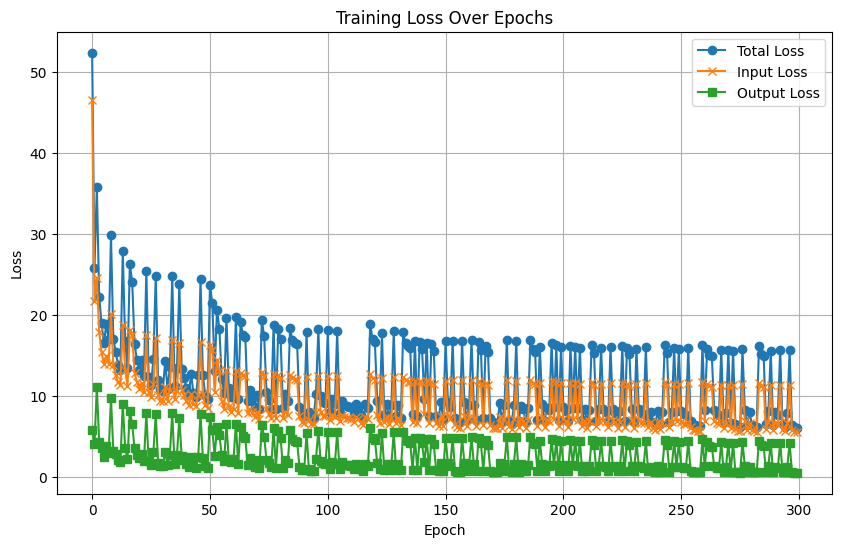

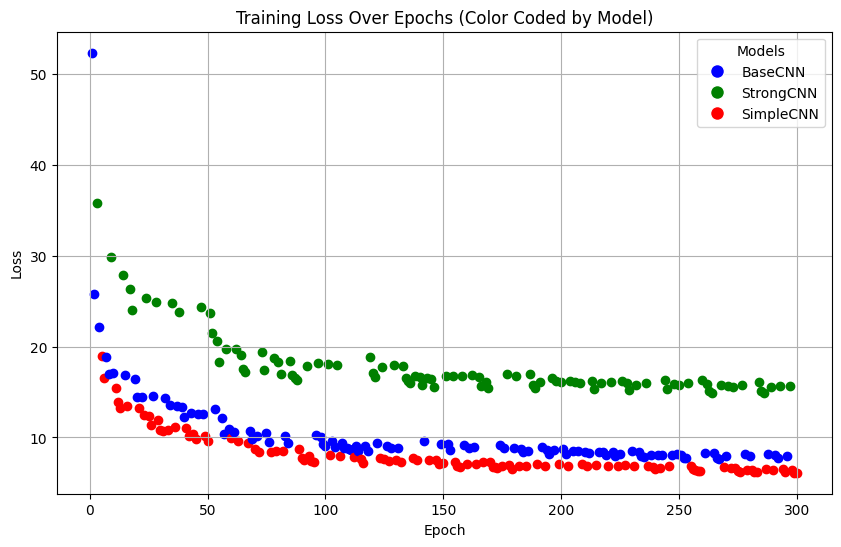

In [18]:
plt.figure(1,figsize=(10, 6))
plt.plot(epoch_losses, label='Total Loss', marker='o')
plt.plot(epoch_input_losses, label='Input Loss', marker='x')
plt.plot(epoch_output_losses, label='Output Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


model_colors = {
    "BaseCNN": "blue",
    "StrongCNN": "green",
    "SimpleCNN": "red"
}
plt.figure(2,figsize=(10, 6))

for i, loss in enumerate(epoch_losses):
    # Use plot to connect the points with lines
    

    # Scatter individual points
    plt.scatter(i + 1, loss, color=model_colors[epoch_models[i]], label=epoch_models[i] if i == 0 or epoch_models[i] != epoch_models[i-1] else '')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Color Coded by Model)')
plt.grid(True)

# Create a legend for the models
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=model) for model, color in model_colors.items()]
plt.legend(handles=handles, title="Models")

plt.show()

# VERIFICATION

In [13]:
# Save the ATN in the newer `.keras` format for future compatibility

# Define model naming function
def generate_model_name(base_name, beta, epochs, structure):
    # Format the model name with hyperparameters
    return f"{base_name}_beta-{beta}_epochs-{epochs}_{structure}.keras"

# Specify model details
#base_name = "adversarial_transformation_network"

#structure = "conv2d_transpose"  # Example structure (descriptive)

# Generate the model name
#model_name = generate_model_name(base_name, beta, epochs, structure)
model_name='ATN_model/ATNMultuCNN_ATN2.keras'
# Save the ATN with the generated name
atn.save(model_name)
print(f"ATN saved successfully as {model_name}")



ATN saved successfully as ATN_model/ATNMultuCNN_ATN2.keras


In [14]:
# Load Model


#loaded_atn_model = tf.keras.models.load_model('ATN_model/ATNPure.keras')

1/1 [==============================] - 0s 33ms/step
True Labels: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Original Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Transformed Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 8 4 9 3]
1/1 [==============================] - 0s 32ms/step


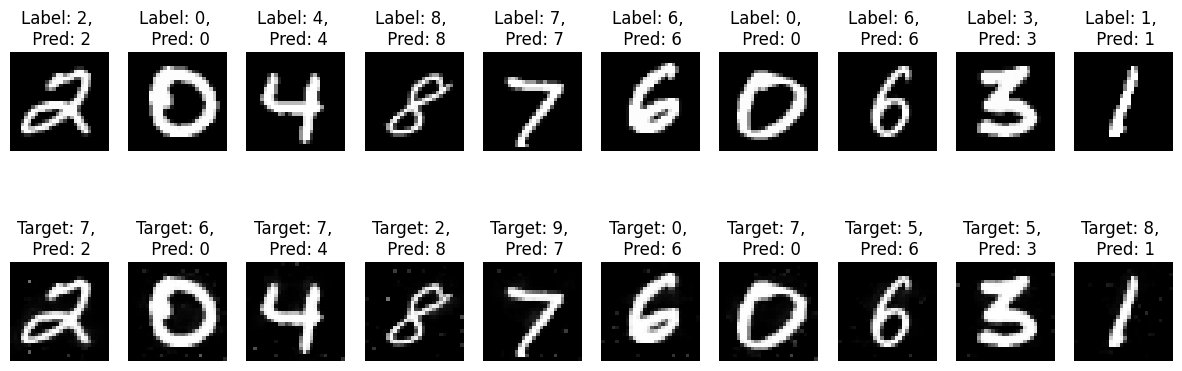

In [17]:

import matplotlib.pyplot as plt







# Function to evaluate and compare results
def evaluate_atn(original_model, atn, dataset):
    for x_batch, y_original_batch in dataset.take(1):  # Take one batch (two elements per batch in the dataset)
        # Generate transformed images
        x_transformed = atn.predict(x_batch)

        # Get predictions for the original and transformed images
        y_pred_original = tf.argmax(original_model.predict(x_batch), axis=1)
        y_pred_transformed = tf.argmax(original_model.predict(x_transformed), axis=1)

        # Get true labels
        y_true = tf.argmax(y_original_batch, axis=1)

        # Print results for comparison
        print("True Labels:", y_true.numpy())
        print("Original Predictions:", y_pred_original.numpy())
        print("Transformed Predictions:", y_pred_transformed.numpy())

        # Display images
        display_images(x_batch, x_transformed, y_true, y_pred_original, y_pred_transformed, original_model.predict(x_batch))
        break  # Only evaluate one batch for now

# Function to display images
def display_images(original_images, transformed_images, y_true, y_pred_original, y_pred_transformed, original_pred):
    num_images = min(10, len(original_images))  # Display up to 10 images
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(original_images[i]), cmap='gray')  # Remove channel for grayscale display
        plt.title(f"Label: {y_true[i].numpy()}, \n Pred: {y_pred_original[i].numpy()}")
        plt.axis('off')

        # Transformed image
        second_highest_target = get_second_highest_target(original_pred[i: i + 1])[0]  # Compute target dynamically
        second_highest_class = tf.argmax(second_highest_target).numpy()

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(transformed_images[i]), cmap='gray')
        plt.title(f"Target: {second_highest_class}, \n Pred: {y_pred_transformed[i].numpy()}")
        plt.axis('off')

    plt.show()


# Evaluate the ATN on the test dataset
evaluate_atn(original_model, atn, mnist_test_atn)


In [16]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, atn=None):
    correct = 0
    total = 0

    for x_batch, y_original_batch in dataset:  # Only unpack two elements
        if atn:
            # Transform images using ATN
            x_batch = atn.predict(x_batch, verbose=0)  # Suppress verbose output
        # Get predictions from the model
        y_pred = tf.argmax(model.predict(x_batch, verbose=0), axis=1)
        y_true = tf.argmax(y_original_batch, axis=1)  # True labels
        # Count correct predictions
        correct += tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)).numpy()
        total += x_batch.shape[0]  # Batch size
    
    return correct / total  # Calculate accuracy


# Original accuracy
original_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=None)
print(f"Accuracy on original images: {original_accuracy:.4f}")

# Transformed accuracy
transformed_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=atn)
print(f"Accuracy on transformed images: {transformed_accuracy:.4f}")


Accuracy on original images: 0.9870
Accuracy on transformed images: 0.9781
